# Teleportación cuántica (Quantum teleportation)

## Descripción del protocolo.

La **teleportación cuántica** es un protocolo que permite transferir un estado cuántico desconocido ($|\psi\rangle$) de un lugar a otro (de Alice a Bob) sin mover físicamente la partícula que lo porta.

Esto se logra utilizando **dos bits de comunicación clásica** y un **par de qubits entrelazados** (un estado de Bell) compartido previamente entre Alice y Bob.

### Recursos utilizados
- 3 qubits (q0: el estado $|\psi\rangle$ de Alice, q1: el qubit de Alice, q2: el qubit de Bob)
- 2 bits clásicos (para la medición de Alice)
- Entrelazamiento compartido (estado de Bell |Φ⁺⟩)

### Idea principal
Alice entrelaza el qubit que quiere enviar ($|\psi\rangle$) con su mitad del par de Bell. Luego, mide sus dos qubits y envía el resultado (dos bits clásicos) a Bob. Bob usa esta información clásica para aplicar una de cuatro posibles correcciones (compuertas `X` y/o `Z`) a su qubit.

Al final del proceso, el qubit de Bob se transforma en una copia exacta del estado $|\psi\rangle$ original de Alice. El estado original de Alice es destruido en la medición.

In [1]:
# Importaciones necesarias y conexión opcional a IBM Quantum 
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import Aer
from qiskit_ibm_runtime import Sampler


# Cargar credenciales
try:
    service = QiskitRuntimeService()
    backend = service.backend("ibm_brisbane")
    print("Conexión con IBM Quantum Platform exitoso")
except Exception:
    backend = Aer.get_backend("aer_simulator")
    print("Utilizando el simulador de AER")

Conexión con IBM Quantum Platform exitoso


## Procedimiento

El protocolo consta de **cinco etapas** principales:

1.  **Preparación del estado a enviar:**
    * Alice prepara el qubit `q0` en un estado cuántico desconocido $|\psi\rangle$ que desea teleportar.
    
2.  **Preparación del estado entrelazado (Bell pair):**
    * Se crea el estado |Φ⁺⟩ = (|00⟩ + |11⟩)/√2 entre `q1` (que tiene Alice) y `q2` (que tiene Bob).
    
3.  **Medición de Alice (Base de Bell):**
    * Alice aplica una puerta `CX` (control `q0`, objetivo `q1`) y una puerta `H` (sobre `q0`).
    * Mide sus dos qubits (`q0` y `q1`) y almacena los resultados en dos bits clásicos (`c0` y `c1`).
    
4.  **Comunicación Clásica:**
    * Alice envía sus dos bits clásicos (00, 01, 10, o 11) a Bob por un canal clásico.
    
5.  **Decodificación por Bob:**
    * Bob, basándose en los bits que recibió, aplica compuertas condicionales a su qubit (`q2`):
        * Si `c1` (de `q1`) es 1, aplica una compuerta `X`.
        * Si `c0` (de `q0`) es 1, aplica una compuerta `Z`.
    * Al final de este paso, el qubit `q2` de Bob se ha transformado en una copia idéntica del estado $|\psi\rangle$ original de Alice.

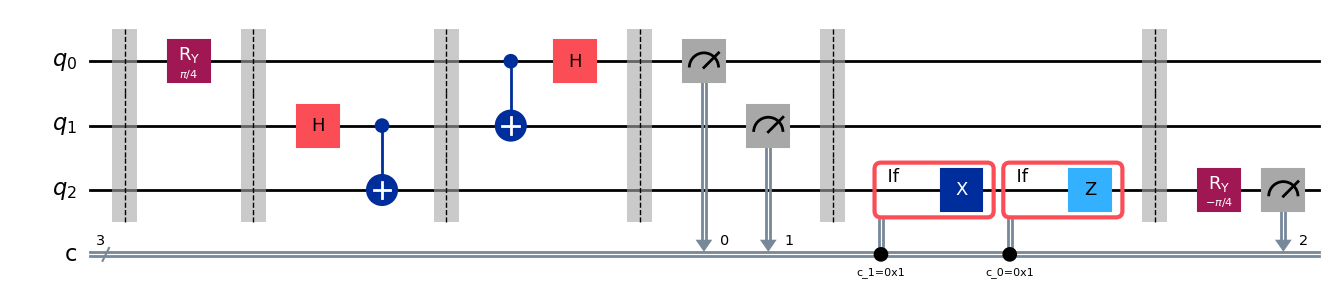

In [2]:
import numpy as np

# Definir los registros
# Se definen: 
# 3 qubits: q0 (psi), q1 (Alice), q2 (Bob)
# 3 bits clásicos: c0, c1 (medición de Alice), c2 (verificación de Bob)
qc = QuantumCircuit(3, 3)
qc.barrier()

# Preparar el estado a enviar (psi) ---
# Creamos un estado arbitrario |psi> en el qubit 0 (de Alice)
# Vamos a usar un ángulo de pi/4 para que no sea |0> ni |1>
psi_angle = np.pi / 4
qc.ry(psi_angle, 0)
qc.barrier()

# Preparar el estado entrelazado (Bell) ---
# Creamos el par Bell entre el qubit 1 (Alice) y 2 (Bob)
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Medición de Alice (Base de Bell) ---
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Medición y Comunicación Clásica ---
# Alice mide sus qubits q0 y q1 en los bits clásicos c0 y c1
qc.measure([0, 1], [0, 1])
qc.barrier()

# Decodificación por Bob (Condicional) ---
# Bob aplica correcciones a su qubit (q2)
# basadas en los bits clásicos que recibió de Alice.
with qc.if_test((1, 1)):  # Si el bit clásico c1 es 1
    qc.x(2)
with qc.if_test((0, 1)):  # Si el bit clásico c0 es 1
    qc.z(2)
qc.barrier()

# Verificación (Opcional pero recomendado) ---
# Para probar que funcionó, aplicamos la inversa de la
# operación de |psi> al qubit de Bob. Si la teleportación
# fue exitosa, el qubit de Bob (q2) debe volver a |0>.
qc.ry(-psi_angle, 2)
qc.measure(2, 2) # Medimos q2 en el bit clásico c2

# --- 8. Dibujar el circuito ---
qc.draw("mpl")

### Explicación del circuito
- **Qubits:** `q0` (estado $|\psi\rangle$), `q1` (Bell de Alice), `q2` (Bell de Bob).
- **Bits Clásicos:** `c0`, `c1` (para Alice), `c2` (para la verificación de Bob).
- **Preparación $|\psi\rangle$:** La compuerta `ry(pi/4)` crea un estado en superposición en `q0`.
- **Entrelazamiento:** La secuencia `H(1) → CX(1, 2)` crea el par de Bell.
- **Medición de Alice:** La secuencia `CX(0, 1) → H(0)` transforma los dos qubits de Alice a la base de Bell, permitiéndole medir el estado.
- **Corrección de Bob:** Las compuertas `X` y `Z` sobre `q2` están controladas clásicamente (`if_test`) por los resultados de la medición de Alice.
- **Verificación:** Al final, aplicamos `ry(-pi/4)` al qubit de Bob. Si la teleportación fue exitosa, su qubit era $|\psi\rangle$, y esta compuerta inversa lo devuelve a `|0⟩`. La medición final en `c2` nos lo confirmará.

Transpilando el circuito para el backend...
Transpilación completada.
Enviando trabajo al Sampler...
Trabajo completado.
Resultados de la medición:


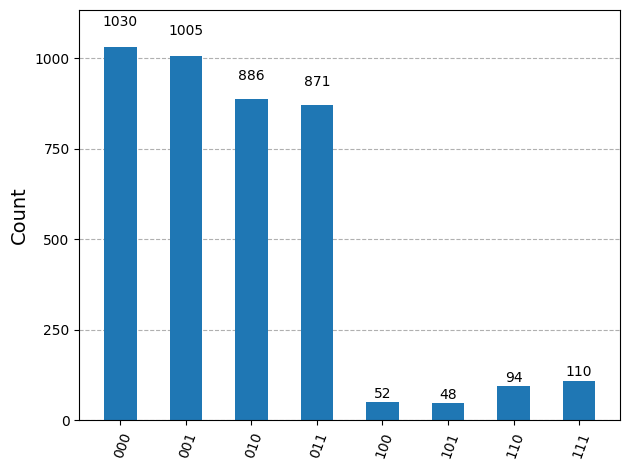

In [3]:
# Ejecución del circuito 

# Transpila tu circuito lógico 'qc' para el 'backend'
#  Esto convierte todas las compuertas (H, RY, CX, IF_TEST) a las compuertas base que el hardware entiende.
print("Transpilando el circuito para el backend...")
tqc = transpile(qc, backend=backend)
print("Transpilación completada.")

# Instancia el Sampler (Primitivo V2) pasando el backend
sampler = Sampler(mode=backend)
print("Enviando trabajo al Sampler...")

# Ejecuta el .run() con el circuito ya transpilado (tqc) y los shots
job = sampler.run([tqc], shots=4096) # Usamos más shots para mejor estadística
result = job.result()
print("Trabajo completado.")

# Obtén los resultados del formato V2
pub_result = result[0]
counts = pub_result.data.c.get_counts()

# Visualización
print("Resultados de la medición:")
plot_histogram(counts)

### Interpretación de resultados
- El histograma muestra los resultados de los 3 bits clásicos, en el formato `c2 c1 c0`.
- Los bits de Alice (`c1 c0`) son aleatorios, por lo que veremos una mezcla de `00`, `01`, `10` y `11` en los dos bits de la derecha.
- **El bit clave es `c2` (el bit de más a la izquierda).**
- Como aplicamos la compuerta inversa al qubit de Bob, si la teleportación fue exitosa, el qubit de Bob *siempre* colapsará a `|0⟩`.
- Por lo tanto, en un simulador ideal, **solo deberíamos ver resultados que comiencen con 0** (ej. `000`, `001`, `010`, `011`). La aparición de resultados que comiencen con `1` (ej. `101`) se debe al ruido del hardware cuántico real.


In [4]:
# (Opcional) Visualización del estado |psi> original
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

# Únicamente se permite la visualización si el backend es un simulador.
if "simulator" in backend.name:
    print("Estado |psi> original (q0) que Alice quería enviar:")
    
    # Creamos un circuito solo con el estado |psi>
    psi_qc = QuantumCircuit(1)
    psi_qc.ry(psi_angle, 0) # Usamos el mismo ángulo de la celda 4
    
    # Calculamos y mostramos el estado
    state = Statevector(psi_qc)
    display(plot_bloch_multivector(state))
    print("\nEl histograma de la celda anterior (con c2=0) demuestra")
    print("que este estado se transfirió exitosamente a q2 (Bob).")
else:
    print(f"No se puede generar el Statevector: El backend '{backend.name}' no es un simulador.")

No se puede generar el Statevector: El backend 'ibm_brisbane' no es un simulador.
